# Multi-Element Airfoil

In [1]:
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import logging
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Read and panel airfoil data
MAIN = main_selig = vft.read_selig("main_element.dat")[:,::-1]
# MAIN = vft.repanel(main_selig, N = 200, TEFAC=1.0)[:,::-1] #180

FLAP0 = vft.read_selig("flap.dat")[:,::-1]
# FLAP0 = vft.repanel(vft.read_selig("NLR7301FlapECARP.dat"),220)[:,::-1] #150

The authors note an offset in the change in distance between flap and main airfoil, as well as a change in twist on the flap. 
This change is applied below, by shifting and rotating the flap.
Such a modification was also used in the analysis in [6].

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

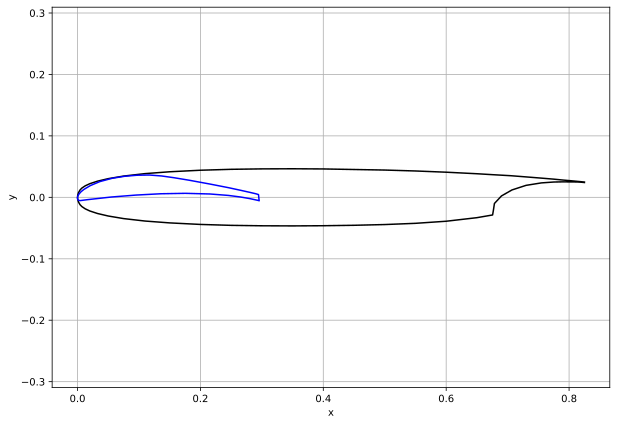

In [3]:
matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

# Rotate flap
center = np.r_[0.94, -0.011]


def rotate(deg, center, x):
    """Rotate airfoil.
    
    Parameters
    ----------
    deg : float
    center : numpy.array
    x : numpy.array
    
    Returns
    -------
    moved : numpy.array
    """

    # Create rotation matrix
    deg2rad = np.pi / 180
    c, s = np.cos(deg * deg2rad), np.sin(deg * deg2rad)
    A = np.array([[c, s], [-s, c]])

    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array,
    # but not 2x1 arrays form an 2xN array.
    moved = ((A @ ((x.T - center.T).T)).T + center.T).T
    
    return moved

FLAP = rotate(-0.25, center, FLAP0)
FLAP[1, :] += 0.0025

# Plot geometry
fig, ax = plt.subplots(1, 1)
ax.plot(MAIN[0, :], MAIN[1, :], "-k")
ax.plot(FLAP[0, :], FLAP[1, :], "-b")
ax.axis("equal")
ax.grid()
ax.set(xlabel = "x", ylabel="y")

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0 or 0.185 using a Karman-Tsien correction for the pressure and lift. A critical amplification factor of 8 was used, while 11.2 seems to be recommended for the Delft low-speed wind tunnel[5].
However, the lower value agrees better with the observed transition (see the pressure distributions below).

In [4]:
# Settings
RE = 2.51e6
ncrit = 8
Mach = 0.0
AOArange = np.arange(start=-2, stop=17, step=0.5)

setup = vf.setup(Re=RE, Ncrit=ncrit, Ma=Mach, Alpha=AOArange[0], Itermax=1000)
setup.Silent = True  # Do not show information on convergence and iterations

# RFOIL-type shear lag fits the measurement slightly better (lower maximum lift)
setup.ShearLagType = 1

results = {}  # Dictionary of results
Mach_vec = [0, 0.185]
res13 = {}
for mach in Mach_vec:

    #  Set Mach number
    setup.Ma = mach

    # When using an outer loop, make sure to re-initialize the solution
    Init = True

    results[mach] = {}
    results[mach]["AOA"] = []
    results[mach]["CL"] = []
    results[mach]["CLi"] = []
    results[mach]["CD"] = []

    for alpha in AOArange:

        setup.Alpha = alpha

        if Init:
            [p, bl, xn] = vf.init([FLAP], setup)
            Init = False

        res = None
        grad = None
        [xn, flag, res, grad, _] = vf.iter(xn, bl, p, setup, res, grad)
        resi = np.sqrt(np.dot(res.T, res))

        if bool(flag) == True:
            results[mach]["AOA"].append(alpha)
            results[mach]["CL"].append(p.CL)
            results[mach]["CLi"].append(p.CLi)
            results[mach]["CD"].append(bl[0].CD)
            #  print('AOA %2.2f CL %f'%(alpha,p.CL))

 xi=0.013721,delta=0.000034,theta=0.000020,ue=1.342038,typ=laminar,
 res=[1.46998,-1.917,1.03904e-05]
 dx=[1.63687e-05,0.0307458,-1.30936e-05]
 x=[2.0276e-05,1.34204,5.98137] 
 lam=0.206451 H=1.672821 HS=1.753329 US=0.000000.

 xi=0.013686,delta=0.000034,theta=0.000020,ue=1.281607,typ=laminar,
 res=[1.36712,-1.91155,8.18163e-06]
 dx=[1.34028e-05,0.0271122,-1.08999e-05]
 x=[2.00547e-05,1.28161,5.87011] 
 lam=0.249383 H=1.706801 HS=1.742240 US=0.000000.

 xi=0.013470,delta=0.000035,theta=0.000018,ue=1.223309,typ=laminar,
 res=[1.19204,-1.70593,8.73427e-06]
 dx=[-5.77414e-05,0.0857864,5.31158e-05]
 x=[1.78658e-05,1.22331,5.06051] 
 lam=0.077353 H=1.939940 HS=1.677928 US=0.000000.

 xi=0.013460,delta=0.000035,theta=0.000019,ue=1.150014,typ=laminar,
 res=[0.899362,-1.59877,3.27889e-06]
 dx=[6.08825e-06,0.00246755,-6.76574e-06]
 x=[1.88262e-05,1.15001,5.08168] 
 lam=0.515369 H=1.885363 HS=1.691296 US=0.000000.

 xi=0.013393,delta=0.000036,theta=0.000019,ue=1.167155,typ=laminar,
 res=[1.23614

 xi=0.031103,delta=0.000027,theta=0.000016,ue=2.669563,typ=laminar,
 res=[0.331999,-0.747064,5.28863e-07]
 dx=[3.06866e-06,0.0827668,-3.69984e-06]
 x=[1.57801e-05,2.66956,7.49865] 
 lam=0.857058 H=1.706861 HS=1.742222 US=0.000000.

 xi=0.030977,delta=0.000033,theta=0.000018,ue=2.099570,typ=laminar,
 res=[0.400485,-0.880011,1.08417e-06]
 dx=[3.76742e-06,0.0571638,-5.05538e-06]
 x=[1.77568e-05,2.09957,8.30705] 
 lam=0.785542 H=1.847490 HS=1.701144 US=0.000000.

 xi=0.136986,delta=0.000020,theta=0.000013,ue=14.784378,typ=turbulent,
 res=[0.172945,-0.134424,-8.01221e-05]
 dx=[-6.47335e-07,1.71865,0.000604356]
 x=[1.31877e-05,14.7844,0.0132392] 
 lam=1.000000 H=1.525926 HS=1.749058 US=0.511378.

 xi=0.030900,delta=0.000034,theta=0.000020,ue=2.048579,typ=laminar,
 res=[0.734224,-1.33081,4.04515e-06]
 dx=[7.789e-06,0.0759875,-6.94653e-06]
 x=[1.95196e-05,2.04858,9.66973] 
 lam=0.417674 H=1.739519 HS=1.732010 US=0.000000.

 xi=0.030727,delta=0.000027,theta=0.000012,ue=2.533115,typ=laminar,
 re

 xi=0.134187,delta=0.000033,theta=0.000023,ue=5.478899,typ=turbulent,
 res=[0.350814,-0.171363,-0.000304641]
 dx=[-1.74378e-06,0.34108,0.00285978]
 x=[2.28133e-05,5.4789,0.0193696] 
 lam=1.000000 H=1.425180 HS=1.792405 US=0.574073.

 xi=0.134131,delta=0.000036,theta=0.000024,ue=6.008580,typ=turbulent,
 res=[0.44777,-0.460611,-0.000381058]
 dx=[-3.72644e-06,0.774424,0.00524375]
 x=[2.43973e-05,6.00858,0.0243761] 
 lam=0.774768 H=1.492144 HS=1.768240 US=0.532791.

 xi=0.134127,delta=0.000038,theta=0.000027,ue=4.902079,typ=turbulent,
 res=[0.00937872,-0.361223,-8.81933e-06]
 dx=[1.63039e-06,-0.0212748,-0.00236863]
 x=[2.66229e-05,4.90208,0.023369] 
 lam=1.000000 H=1.440329 HS=1.786731 US=0.564312.

 xi=0.134123,delta=0.000041,theta=0.000028,ue=4.655870,typ=turbulent,
 res=[0.359675,-0.397434,-0.000230552]
 dx=[-7.26641e-06,0.810894,0.00912691]
 x=[2.8217e-05,4.65587,0.0230458] 
 lam=0.420840 H=1.437388 HS=1.787745 US=0.566162.

 xi=0.134116,delta=0.000043,theta=0.000031,ue=3.884198,typ=tu

 xi=0.028343,delta=0.000039,theta=0.000033,ue=3.313473,typ=turbulent,
 res=[0.0350099,-0.0318996,-0.000285309]
 dx=[-9.82615e-07,0.0536768,0.00140904]
 x=[3.29068e-05,3.31347,0.0250328] 
 lam=1.000000 H=1.181907 HS=1.896598 US=0.772453.

 xi=0.028335,delta=0.000039,theta=0.000033,ue=3.287542,typ=turbulent,
 res=[0.0288965,-0.0261722,-0.000241011]
 dx=[-8.19108e-07,0.0441607,0.00116632]
 x=[3.3085e-05,3.28754,0.0249921] 
 lam=1.000000 H=1.178324 HS=1.898395 US=0.776127.

 xi=0.028321,delta=0.000039,theta=0.000033,ue=3.295921,typ=turbulent,
 res=[0.0310261,-0.028151,-0.000256975]
 dx=[-8.79026e-07,0.0475008,0.00125203]
 x=[3.30511e-05,3.29592,0.0250764] 
 lam=1.000000 H=1.180309 HS=1.897398 US=0.774088.

 xi=0.028349,delta=0.000039,theta=0.000034,ue=3.247454,typ=turbulent,
 res=[-0.00933707,0.000162134,0.000138114]
 dx=[1.3129e-06,-0.0728709,-0.00188338]
 x=[3.36925e-05,3.24745,0.0241159] 
 lam=1.000000 H=1.159189 HS=1.908087 US=0.796192.

 xi=0.014167,delta=0.000024,theta=0.000016,ue=2.

 xi=0.014433,delta=0.000003,theta=0.000001,ue=38.179070,typ=laminar,
 res=[4.58393,-7.33582,4.93196e-07]
 dx=[-1.79739e-06,-13.9241,1.60488e-06]
 x=[1.34701e-06,38.1791,3.13797] 
 lam=0.187357 H=2.033524 HS=1.657112 US=0.000000.

 xi=0.014433,delta=0.000003,theta=0.000001,ue=35.411861,typ=laminar,
 res=[5.20812,-9.60498,5.62306e-07]
 dx=[-3.65218e-06,-46.9515,3.36059e-06]
 x=[1.17682e-06,35.4119,3.13727] 
 lam=0.080556 H=2.314487 HS=1.608174 US=0.000000.

 xi=0.014473,delta=0.000005,theta=0.000003,ue=17.353660,typ=laminar,
 res=[4.84554,-7.61716,7.78898e-07]
 dx=[2.28201e-05,59.0813,-7.96617e-07]
 x=[3.04548e-06,17.3537,4.69828] 
 lam=0.022243 H=1.590961 HS=1.782108 US=0.000000.

 xi=0.014439,delta=0.000007,theta=0.000004,ue=9.138533,typ=laminar,
 res=[6.42496,-7.60067,3.1354e-06]
 dx=[3.37061e-06,1.1366,-3.96754e-06]
 x=[4.24165e-06,9.13853,4.69503] 
 lam=0.209737 H=1.756147 HS=1.726973 US=0.000000.

 xi=0.014434,delta=0.000007,theta=0.000004,ue=7.984552,typ=laminar,
 res=[4.84631,-6.

 xi=0.014231,delta=0.000007,theta=0.000004,ue=8.994830,typ=laminar,
 res=[1.31592,-2.74339,2.98199e-07]
 dx=[8.77345e-07,0.667887,-1.21736e-06]
 x=[3.97461e-06,8.99483,0.630282] 
 lam=0.755044 H=1.858480 HS=1.698236 US=0.000000.

 xi=0.014213,delta=0.000008,theta=0.000004,ue=8.204335,typ=laminar,
 res=[1.89774,-3.09084,1.17655e-06]
 dx=[-3.21532e-06,-1.45855,2.94124e-06]
 x=[3.94625e-06,8.20434,2.17609] 
 lam=0.306831 H=1.993653 HS=1.665669 US=0.000000.

 xi=0.028374,delta=0.000984,theta=0.000644,ue=22.812486,typ=turbulent,
 res=[0.021225,3.8945,0.0167787]
 dx=[-0.00013703,0.0101923,0.000704393]
 x=[0.000643952,22.8125,0.00397292] 
 lam=0.940035 H=1.527740 HS=1.701268 US=0.496608.

 xi=0.014157,delta=0.000007,theta=0.000003,ue=11.820975,typ=laminar,
 res=[3.36287,-4.9481,1.51514e-06]
 dx=[-9.88338e-06,-4.54127,9.17382e-06]
 x=[3.47156e-06,11.821,8.65] 
 lam=0.087813 H=2.025346 HS=1.658831 US=0.000000.

 xi=0.014328,delta=0.000008,theta=0.000003,ue=7.759607,typ=laminar,
 res=[2.50072,-5

 xi=0.014209,delta=0.000015,theta=0.000007,ue=3.441639,typ=laminar,
 res=[1.93531,-3.18124,3.45298e-06]
 dx=[-1.12375e-05,-1.29602,9.16614e-06]
 x=[6.77552e-06,3.44164,4.43854] 
 lam=0.150735 H=2.187127 HS=1.628072 US=0.000000.

 xi=0.014238,delta=0.000016,theta=0.000010,ue=3.507744,typ=laminar,
 res=[1.66376,-2.98616,8.61793e-07]
 dx=[1.78284e-05,1.97186,-9.46396e-07]
 x=[9.56265e-06,3.50774,5.20955] 
 lam=0.089395 H=1.622123 HS=1.770796 US=0.000000.

 xi=0.014225,delta=0.000013,theta=0.000006,ue=4.268258,typ=laminar,
 res=[1.73515,-2.87182,1.87978e-06]
 dx=[-7.78298e-06,-0.829822,7.4133e-06]
 x=[6.34163e-06,4.26826,4.22209] 
 lam=0.203702 H=2.033347 HS=1.657149 US=0.000000.

 xi=0.014213,delta=0.000013,theta=0.000008,ue=4.292298,typ=laminar,
 res=[1.64776,-3.06279,9.24212e-07]
 dx=[2.03018e-05,3.60401,-9.91051e-07]
 x=[8.21513e-06,4.2923,4.38236] 
 lam=0.067442 H=1.607719 HS=1.775969 US=0.000000.

 xi=0.028376,delta=0.000741,theta=0.000476,ue=5.799416,typ=turbulent,
 res=[-0.0172728,

 xi=0.111088,delta=0.048647,theta=0.025797,ue=342.160826,typ=turbulent,
 res=[-0.0251377,0.0995737,0.00764259]
 dx=[-0.00255313,25.5214,-0.0263249]
 x=[0.0257971,342.161,0.339388] 
 lam=1.000000 H=1.885768 HS=1.597573 US=0.346739.

 xi=0.049564,delta=0.001501,theta=0.001475,ue=1.525388,typ=turbulent,
 res=[1.61733e-05,-0.00163773,-6.85958e-06]
 dx=[-6.81945e-07,0.000195705,-1.6524e-05]
 x=[0.00147519,1.52539,0.157663] 
 lam=1.000000 H=1.017162 HS=1.986204 US=0.972914.

 xi=0.111088,delta=0.047074,theta=0.032744,ue=1200.972603,typ=turbulent,
 res=[-1.74127e-05,0.000394547,5.66821e-06]
 dx=[-9.03524e-05,2.41648,-0.000688533]
 x=[0.0327436,1200.97,0.312364] 
 lam=1.000000 H=1.437660 HS=1.736198 US=0.549700.

 xi=0.070553,delta=0.000003,theta=0.000002,ue=363.394459,typ=turbulent,
 res=[-0.0696151,-1.25422,-0.00214854]
 dx=[-6.14765e-07,218.003,0.0011355]
 x=[1.50943e-06,363.394,0.0104902] 
 lam=0.277821 H=1.731344 HS=1.657747 US=0.407033.

 xi=0.111088,delta=0.046307,theta=0.031354,ue=678.

 xi=0.014210,delta=0.000038,theta=0.000020,ue=1.207827,typ=laminar,
 res=[0.518887,-0.995068,3.3449e-06]
 dx=[5.65426e-06,0.00814583,-8.37884e-06]
 x=[2.03822e-05,1.20783,3.47195] 
 lam=0.600792 H=1.840749 HS=1.709778 US=0.000000.

 xi=0.014218,delta=0.000037,theta=0.000024,ue=1.243791,typ=laminar,
 res=[0.539914,-1.02242,1.63432e-06]
 dx=[7.56339e-05,0.464458,-1.72382e-06]
 x=[2.35631e-05,1.24379,2.09286] 
 lam=0.051924 H=1.563536 HS=1.802144 US=0.000000.

 xi=0.014222,delta=0.000037,theta=0.000024,ue=1.259257,typ=laminar,
 res=[0.56816,-1.0563,1.90295e-06]
 dx=[0.000209199,1.3325,-1.93929e-06]
 x=[2.35178e-05,1.25926,2.43182] 
 lam=0.018736 H=1.553995 HS=1.806179 US=0.000000.

 xi=0.014222,delta=0.000037,theta=0.000016,ue=1.214784,typ=laminar,
 res=[0.709151,-1.44221,2.32294e-06]
 dx=[-0.000134368,-0.849737,-2.39348e-06]
 x=[1.58391e-05,1.21478,2.80224] 
 lam=0.029470 H=2.304503 HS=1.613742 US=0.000000.

 xi=0.014221,delta=0.000036,theta=0.000016,ue=1.219986,typ=laminar,
 res=[0.7157

 xi=0.014238,delta=0.000033,theta=0.000015,ue=1.383264,typ=laminar,
 res=[0.838489,-1.56922,6.70232e-06]
 dx=[-3.29577e-05,-0.329154,2.95281e-05]
 x=[1.46113e-05,1.38326,3.39652] 
 lam=0.110834 H=2.262301 HS=1.621622 US=0.000000.

 xi=0.014238,delta=0.000033,theta=0.000015,ue=1.383531,typ=laminar,
 res=[0.838311,-1.5693,6.69811e-06]
 dx=[-3.29787e-05,-0.329562,2.95534e-05]
 x=[1.46085e-05,1.38353,3.39579] 
 lam=0.110742 H=2.262449 HS=1.621600 US=0.000000.

 xi=0.014238,delta=0.000033,theta=0.000015,ue=1.383289,typ=laminar,
 res=[0.838474,-1.56931,6.7012e-06]
 dx=[-3.29672e-05,-0.329301,2.95388e-05]
 x=[1.46105e-05,1.38329,3.39639] 
 lam=0.110796 H=2.262349 HS=1.621614 US=0.000000.

 xi=0.014238,delta=0.000033,theta=0.000015,ue=1.382974,typ=laminar,
 res=[0.838628,-1.5693,6.70445e-06]
 dx=[-3.29585e-05,-0.329026,2.9527e-05]
 x=[1.4613e-05,1.38297,3.39692] 
 lam=0.110844 H=2.262248 HS=1.621628 US=0.000000.

 xi=0.014238,delta=0.000033,theta=0.000015,ue=1.383264,typ=laminar,
 res=[0.83840

 xi=0.014283,delta=0.000033,theta=0.000019,ue=1.456469,typ=laminar,
 res=[0.569297,-1.03466,2.98079e-06]
 dx=[6.18926e-06,0.0370451,-5.99235e-06]
 x=[1.86632e-05,1.45647,2.39966] 
 lam=0.502568 H=1.745935 HS=1.741264 US=0.000000.

 xi=0.014283,delta=0.000033,theta=0.000019,ue=1.456270,typ=laminar,
 res=[0.568699,-1.03428,2.97445e-06]
 dx=[6.17955e-06,0.0370367,-5.98819e-06]
 x=[1.86603e-05,1.45627,2.39859] 
 lam=0.503282 H=1.746240 HS=1.741165 US=0.000000.

 xi=0.014259,delta=0.000033,theta=0.000020,ue=1.469300,typ=laminar,
 res=[0.761568,-1.18364,4.49023e-06]
 dx=[1.68942e-05,0.144544,-5.60362e-06]
 x=[2.01405e-05,1.4693,2.71633] 
 lam=0.198692 H=1.631879 HS=1.780207 US=0.000000.

 xi=0.094081,delta=0.000067,theta=0.000043,ue=4.614193,typ=turbulent,
 res=[-0.500986,0.276107,-0.00149558]
 dx=[-1.69935e-05,1.85348,-0.00623654]
 x=[4.31361e-05,4.61419,0.0103068] 
 lam=0.413161 H=1.555156 HS=1.996964 US=0.980000.

 xi=0.294758,delta=0.000063,theta=0.000015,ue=5.790508,typ=turbulent,
 res=

 xi=0.014347,delta=0.000033,theta=0.000017,ue=1.416094,typ=laminar,
 res=[0.385544,-0.845577,2.29825e-07]
 dx=[3.47315e-06,0.0321481,-1.25967e-06]
 x=[1.70369e-05,1.41609,0.597087] 
 lam=0.817552 H=1.931175 HS=1.688691 US=0.000000.

 xi=0.014346,delta=0.000033,theta=0.000017,ue=1.420189,typ=laminar,
 res=[0.385669,-0.845972,2.28707e-07]
 dx=[3.46584e-06,0.0323023,-1.25536e-06]
 x=[1.70065e-05,1.42019,0.60423] 
 lam=0.817816 H=1.931716 HS=1.688610 US=0.000000.

 xi=0.014347,delta=0.000033,theta=0.000017,ue=1.414087,typ=laminar,
 res=[0.385305,-0.845427,2.27291e-07]
 dx=[3.46929e-06,0.0321131,-1.2522e-06]
 x=[1.70374e-05,1.41409,0.583739] 
 lam=0.818487 H=1.932294 HS=1.688387 US=0.000000.

 xi=0.014345,delta=0.000033,theta=0.000018,ue=1.400285,typ=laminar,
 res=[0.389114,-0.836648,1.16316e-06]
 dx=[3.79538e-06,0.0298555,-5.23024e-06]
 x=[1.77079e-05,1.40028,0.771288] 
 lam=0.777609 H=1.881852 HS=1.701121 US=0.000000.

 xi=0.014345,delta=0.000033,theta=0.000017,ue=1.398579,typ=laminar,
 r

 xi=0.014385,delta=0.000032,theta=0.000016,ue=1.494443,typ=laminar,
 res=[0.5104,-0.863158,4.10318e-06]
 dx=[-1.1371e-05,-0.0481045,1.12602e-05]
 x=[1.61266e-05,1.49444,0.0207872] 
 lam=0.354556 H=2.011561 HS=1.670700 US=0.000000.

 xi=0.014380,delta=0.000032,theta=0.000016,ue=1.496547,typ=laminar,
 res=[0.50892,-0.865686,4.08651e-06]
 dx=[-1.12464e-05,-0.0496999,1.11404e-05]
 x=[1.60737e-05,1.49655,0.0165592] 
 lam=0.357306 H=2.015060 HS=1.669942 US=0.000000.

 xi=0.174435,delta=0.000592,theta=0.000319,ue=4.951474,typ=turbulent,
 res=[-0.418308,0.0895169,-0.00299499]
 dx=[0.00031445,-2.66503,0.00939806]
 x=[0.000318557,4.95147,0.0151481] 
 lam=0.168843 H=1.859226 HS=1.920624 US=0.891182.

 xi=0.014381,delta=0.000033,theta=0.000017,ue=1.489097,typ=laminar,
 res=[0.529422,-0.848018,4.58915e-06]
 dx=[-1.27015e-05,-0.0330021,1.20161e-05]
 x=[1.65058e-05,1.4891,0.05897] 
 lam=0.324879 H=1.981919 HS=1.677425 US=0.000000.

 xi=0.014382,delta=0.000033,theta=0.000016,ue=1.483455,typ=laminar,
 

LinAlgError: Singular matrix

In [6]:
pd.DataFrame(results[0]).set_index("AOA")

,CL,CLi,CD
AOA,,,
-2.0,0.175895,0.573070,0.007583
-1.5,0.192925,0.590547,0.006477
-1.0,0.210948,0.607979,0.005568
-0.5,0.229084,0.625364,0.004664
0.0,0.245674,0.642701,0.004319
0.5,0.262485,0.659989,0.004056
1.0,0.278995,0.677227,0.003902
1.5,0.294750,0.694414,0.003861
2.0,0.310228,0.711548,0.003857


array([<AxesSubplot:xlabel='AOA'>, <AxesSubplot:xlabel='AOA'>,
       <AxesSubplot:xlabel='AOA'>], dtype=object)

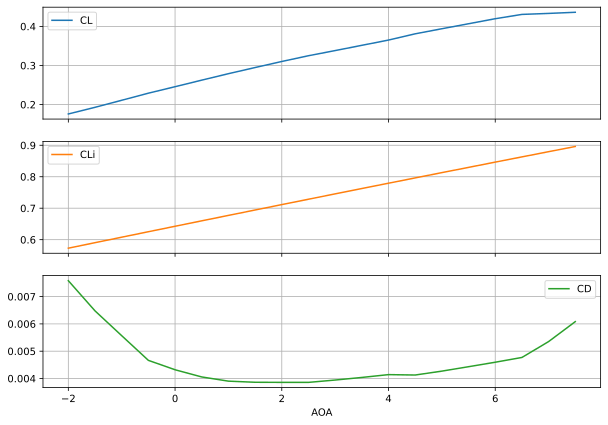

In [5]:
pd.DataFrame(results[0]).set_index("AOA").plot(subplots=True, grid=True)

In [ ]:
# Read experimental data
EXPRES=np.genfromtxt("NLRLIFTSLOPE.csv",delimiter=",",names=True)

fix,ax = plt.subplots(1,2)
ax[0].plot(EXPRES['MEAS_X'],EXPRES['MEAS_Y'],marker=".",linestyle = 'None', color="tab:blue",label="Experimental Lift")
for val in Mach_vec:
    ax[0].plot(np.array(results[val]["AOA"]),np.asarray(results[val]["CL"]),marker=None,label="Calculation Mach %g"%val)
ax[0].plot(np.array(results[val]["AOA"]),results[val]["CLi"],marker=None,label="Inviscid Lift")

ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[0].legend()
ax[0].set_xlim([-2, 17])
ax[0].set_ylim([1.5, 3.5])

EXPRESD=np.genfromtxt("NLRDRAGSLOPE.csv",delimiter=",",names=True)
ax[1].plot(EXPRESD['MEAS_X'],EXPRESD['MEAS_Y'],marker=".",linestyle = 'None', color="tab:blue",label="Experimental Drag")
for val in Mach_vec:
    ax[1].plot(results[val]["AOA"],results[val]["CD"],marker=None,label="Calculation Mach %g"%val)

ax[1].set_ylim([0, 0.08]) 
ax[1].set_xlim([-2, 17])
ax[1].set_xlabel('AOA')
ax[1].set_ylabel('CD')
ax[1].legend();

The viscous calculations accurately predict the change in lift slope compared to the inviscid calculations. 
Applying the Mach corrections does result in a worse prediction compared to the incompressible calculation.
This seems to be in line with the results in [2], where the authors choose not to use a Mach correction for this case, but do use one for another case at the same Mach number.
In the following, the pressure distributions are compared to the incompressible calculations.

In [ ]:
# Set-up and initialize based on inviscid panel solution
s.Ma = 0.0

# Experimental 6° has the same lift as numerical 5.5°
s.Alpha = 6
[p6,bl6,x] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl6,p6,s,None,None)

# Experimental 13.1° has the same lift as numerical 12.6°
s.Alpha = 13.1
[p13,bl13,_] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl13,p13,s,None,None)

In [ ]:

# Shorthand for plotting all info for a single AOA from the csv dataset
def plot_cp_exp(ax,EXPRES):
    ax.plot(EXPRES['EXPMAINCP_X'],EXPRES['EXPMAINCP_Y'],marker="o",linestyle = 'None', color="tab:blue",label="Experiment")
    ax.plot(EXPRES['EXPFLAPCP_X']+.1,EXPRES['EXPFLAPCP_Y'],marker="o",linestyle = 'None', color="tab:blue")
    ax.plot(EXPRES['EXPMAINTR_X'],EXPRES['EXPMAINTR_Y'],marker="D",linestyle = 'None', color="tab:orange",label="Experimental transition region")
    ax.plot(EXPRES['EXPFLAPTR_X']+.1,EXPRES['EXPFLAPTR_Y'],marker="D",linestyle = 'None', color="tab:orange")

# Shorthand for plotting all info from the calculations for a single AOA
def plot_cp(ax,p,bl):
    # A helper index, cp is a single array of pressures over all panel nodes
    IMF = [range(0,p.foils[0].N),range(p.foils[0].N,p.foils[0].N+p.foils[1].N)]
    
    ax.plot(np.array(p.foils[0].X[0,:]),-p.cp[IMF[0]],marker="None",color="tab:blue",label="Viscous calculation")
    ax.plot(np.array(p.foils[1].X[0,:]+.1),-p.cp[IMF[1]],marker="None",color="tab:blue")
    ax.plot(np.array(p.foils[0].X[0,:]),-p.cp_inviscid[IMF[0]],':',marker="None",color="tab:green",label="Inviscid calculation")
    ax.plot(np.array(p.foils[1].X[0,:]+.1),-p.cp_inviscid[IMF[1]],':',marker="None",color="tab:green")

    for k in range(2):
        tr_lo = np.interp(bl[k].ST+bl[k].bl_fl.node_tr_lo.xi[0],p.foils[k].S,p.foils[k].X[0,:]+k*.1)
        tr_up = np.interp(bl[k].ST-bl[k].bl_fl.node_tr_up.xi[0],p.foils[k].S,p.foils[k].X[0,:]+k*.1)
        cp_up = np.interp(bl[k].ST-bl[k].bl_fl.node_tr_up.xi[0],p.foils[k].S,np.asarray(p.cp[IMF[k]]).ravel())
        cp_lo = np.interp(bl[k].ST+bl[k].bl_fl.node_tr_lo.xi[0],p.foils[k].S,np.asarray(p.cp[IMF[k]]).ravel())
        ax.plot(tr_lo,-cp_lo,'v',color="tab:red",label="Numerical transition point")
        ax.plot(tr_up,-cp_up,'v',color="tab:red")

    ax.set_xlabel('x/c')
    ax.set_ylabel('-cp')

# Read and plot data for 6° AoA
EXPRES=np.genfromtxt("NLRCP55.csv",delimiter=",",names=True)
fig,ax = plt.subplots(1,1)
plot_cp_exp(ax,EXPRES)
plot_cp(ax,p6,bl6)
ax.set_title('Main Airfoil 6° AOA')
ax.legend()

# Read and plot data for 13.1° AoA
EXPRES=np.genfromtxt("NLRCP126.csv",delimiter=",",names=True)
fig,ax = plt.subplots(1,1)
plot_cp_exp(ax,EXPRES)
plot_cp(ax,p13,bl13)
ax.legend();



[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun Chen. *Calculation of multielement airfoil flows, including flap wells.* 34th Aerospace Sciences Meeting and Exhibit. 1996.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.

[6] Godin, P., D. W. Zingg, and T. E. Nelson. *High-lift aerodynamic computations with one-and two-equation turbulence models.* AIAA journal 35.2 (1997): 237-243.

[7] Haase, W. et al. *ECARP - European Computational Aerodynamics Research Projects: Validation of CFD Codes and Assessment of Turbulence Models.* Notes on Numerical Fluid Mechanics, Vol. 58, 1997. 